In [2]:
#!pip install mplfinance
#!pip install tensorflow
#!pip install pydot
#!pip install graphviz
#!pip install pydotplus

In [3]:

#from google.colab import drive
#drive.mount('/content/drive')
import datetime
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization,Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow. keras.preprocessing. sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
#download data 
start =datetime(2018,9,17)
end = datetime(2022,8,1)
symbol=['BTC-USD']
base_data= yf.download(tickers=symbol,start=start,end=end) 
base_data=base_data.drop('Adj Close', axis=1)
base_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-09-16,222.802994,222.802994,211.117996,220.589005,1502260000
2018-09-17,221.582001,224.261002,195.307999,197.875000,2019910000
2018-09-18,197.095001,213.356995,195.934006,209.975006,1800640000
2018-09-19,209.472000,213.871002,201.656006,209.968994,1733330000
2018-09-20,210.287994,224.817993,207.789001,224.591003,1782070000
...,...,...,...,...,...
2022-07-27,1443.726807,1636.799438,1423.618896,1636.232666,23007524016
2022-07-28,1636.231934,1774.576416,1604.890991,1725.468140,27231399966
2022-07-29,1725.623901,1759.884033,1662.791138,1727.406982,23249531113


In [5]:
txt = base_data.values[0]
print(txt)
data = base_data#.iloc[:,1:]
data.shape
d = data
print(len(d))
print(len(d.iloc[0])) # אורך שורה אחת של נתונים
print(d.iloc[0]) # דוגמה לשורת הנתונים הראשונה
#אנו מציגים את הראשונים מנקודת ההתחלה והעצירה הארוכה
start = 100 #איפה אנחנו מתחילים
#stop = data.shape[0] #כמה נקודות לצייר
length = 300 #כמה נקודות לצייר
#מלא את שמות הטקסט של ערוצי הנתונים
chanelNames = ['Open', 'High', 'Low', 'Close', 'Volume']

[2.22802994e+02 2.22802994e+02 2.11117996e+02 2.20589005e+02
 1.50226000e+09]
1415
5
Open      2.228030e+02
High      2.228030e+02
Low       2.111180e+02
Close     2.205890e+02
Volume    1.502260e+09
Name: 2018-09-16 00:00:00, dtype: float64


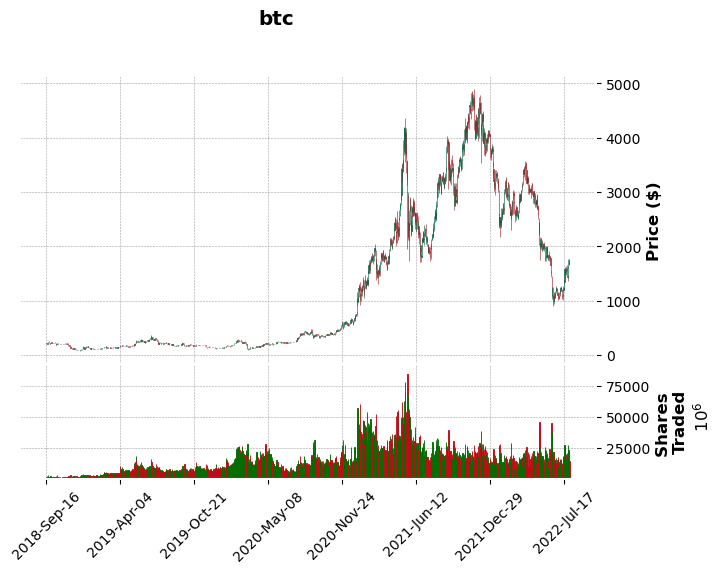

In [6]:
#ציור גרפי נתונים
import mplfinance          as mpf
mpf.plot(data, type='candle', style='charles',
            title='btc',
            ylabel='Price ($)',
            ylabel_lower='Shares \nTraded',
            volume=True,) 

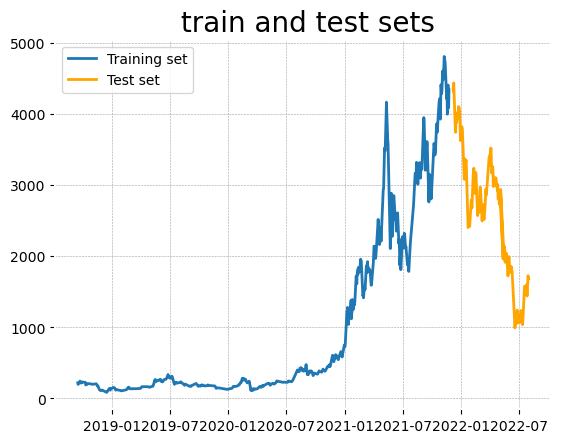

In [7]:
#יצירת פרמטרים של טעינת נתונים
xLen = 10
valLen = 250
trainLen = data.shape[0]-valLen
#חלקו את הנתונים למערכות הדרכה ומבחנים
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

plt.title(' train and test sets', size=20)
plt.plot(xTrain.Close, label='Training set')
plt.plot(xTest.Close, label='Test set', color='orange')
plt.legend();
#שנה את הנתונים (בנפרד עבור X ו-Y)
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)


In [8]:
#עושים reshape,כי יש לנו רק עמודה אחת עם ערך אחד
yTrain, yTest = np.expand_dims(data[:trainLen]['Close'], axis = 1),np.expand_dims(data[trainLen+xLen+2:]['Close'], axis = 1)
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)
#יצירת מחולל הדרכה
trainDataGen = TimeseriesGenerator(xTrain, yTrain,
                                   length=xLen, stride=1, sampling_rate=1, #
                                   batch_size=5)
#צור מחולל דומה עבור אימות ההדרכה
testDataGen = TimeseriesGenerator(xTest, yTest,
                                  length=xLen, stride=1,
                                  batch_size=5)
yTrain[0]
xTrain[0]
print(trainDataGen[0][0].shape,trainDataGen[0][1].shape)

(5, 10, 5) (5, 1)


In [9]:
# פונקציית ספירת חיזוי רשת
def getPred(currModel, xVal, yVal, yScaler):
 # חיזוי תגובת הרשת על מדגם הבדיקה
 predVal = yScaler.inverse_transform(currModel.predict(xVal))
 yValUnscaled = yScaler.inverse_transform(yVal)
 return (predVal, yValUnscaled)


#פונקציה לחישוב המתאם של שני וקטורים חד מימדיים
def correlate(a, b):
# בואו לחשב את האינדיקטורים העיקריים
  ma = a.mean() # ערך ממוצע של הווקטור הראשון
  mb = b.mean() # ערך ממוצע של הווקטור השני
  mab = (a*b).mean() # ערך ממוצע של מכפלת הוקטורים
  sa = a.std() # סטיית תקן של הווקטור הראשון
  sb = b.std() # סטיית התקן של הווקטור השני
  #חשב מתאם
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
def MAD(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)))
    return mape
#בואו ניצור מחולל דגימות בדיקה, שממנו נשלוף את xVal, yVal לבדיקה
DataGen = TimeseriesGenerator(xTest, yTest,length=10, sampling_rate=1,
                              batch_size=len(xTest)) #גודל אצווה יהיה שווה לאורך המדגם שלנו
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
  xVal = np.array(xVal)
  yVal = np.array(yVal)

In [10]:
#צור רשת עצבית
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="relu" )) # 5 - מספר ערוצים
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))
#קומפילציה
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))
modelD.summary()
#אימון השקה
history = modelD.fit(trainDataGen,epochs=50,verbose=1,validation_data = testDataGen)
#קומפילציה
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
#אימון השקה
history = modelD.fit(trainDataGen,epochs=50,verbose=1,validation_data = testDataGen)
#קומפילציה
modelD.compile(loss="mse", optimizer=Adam(lr=1e-6))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 150)           900       
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1501      
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
231/231 [==============================] - 2s 1ms/step - loss: 0.0365 - val_loss: 0.0033
Epoch 2/50
231/231 [==============================] - 0s 835us/step - loss: 0.0013 - val_loss: 0.0034
Epoch 3/50
231/231 [==============================] - 0s 813us/step - loss: 0.0010 - val_loss: 0.0026
Epoch 4/50
231

231/231 [==============================] - 0s 809us/step - loss: 3.2743e-04 - val_loss: 0.0010
Epoch 21/50
231/231 [==============================] - 0s 804us/step - loss: 3.2099e-04 - val_loss: 0.0010
Epoch 22/50
231/231 [==============================] - 0s 800us/step - loss: 3.2041e-04 - val_loss: 0.0013
Epoch 23/50
231/231 [==============================] - 0s 822us/step - loss: 3.2309e-04 - val_loss: 0.0010
Epoch 24/50
231/231 [==============================] - 0s 809us/step - loss: 3.1800e-04 - val_loss: 0.0012
Epoch 25/50
231/231 [==============================] - 0s 817us/step - loss: 3.2242e-04 - val_loss: 0.0010
Epoch 26/50
231/231 [==============================] - 0s 813us/step - loss: 3.2452e-04 - val_loss: 0.0011
Epoch 27/50
231/231 [==============================] - 0s 809us/step - loss: 3.2259e-04 - val_loss: 0.0010
Epoch 28/50
231/231 [==============================] - 0s 801us/step - loss: 3.2139e-04 - val_loss: 0.0011
Epoch 29/50
231/231 [============================

In [11]:
#אימון השקה
history = modelD.fit(trainDataGen,epochs=50,verbose=1,validation_data = testDataGen)
#חיזוי נתונים על ידי הרשת הנוכחית
currModel = modelD #בחירת הדגם הנוכחי
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #  חיזוי נתונים


Epoch 1/50
231/231 [==============================] - 0s 1ms/step - loss: 3.0951e-04 - val_loss: 9.8933e-04
Epoch 2/50
231/231 [==============================] - 0s 835us/step - loss: 3.0843e-04 - val_loss: 0.0010
Epoch 3/50
231/231 [==============================] - 0s 800us/step - loss: 3.0765e-04 - val_loss: 0.0010
Epoch 4/50
231/231 [==============================] - 0s 826us/step - loss: 3.0806e-04 - val_loss: 0.0010
Epoch 5/50
231/231 [==============================] - 0s 826us/step - loss: 3.0771e-04 - val_loss: 0.0010
Epoch 6/50
231/231 [==============================] - 0s 817us/step - loss: 3.0750e-04 - val_loss: 0.0010
Epoch 7/50
231/231 [==============================] - 0s 839us/step - loss: 3.0776e-04 - val_loss: 0.0010
Epoch 8/50
231/231 [==============================] - 0s 809us/step - loss: 3.0809e-04 - val_loss: 0.0010
Epoch 9/50
231/231 [==============================] - 0s 822us/step - loss: 3.0770e-04 - val_loss: 0.0010
Epoch 10/50
231/231 [=======================

יישום של קונבולציה חד מימדית(Conv1D)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             1664      
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

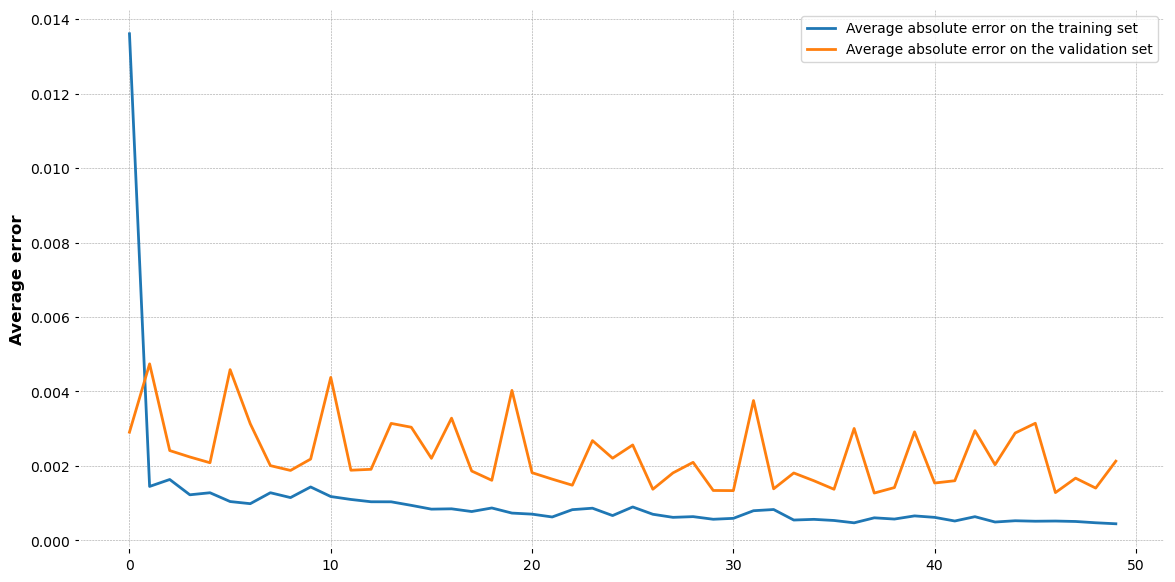

8/8 [==============================] - 0s 857us/step
Epoch 1/20
231/231 [==============================] - 1s 1ms/step - loss: 3.7045e-04 - val_loss: 0.0015
Epoch 2/20
231/231 [==============================] - 0s 960us/step - loss: 3.7218e-04 - val_loss: 0.0014
Epoch 3/20
231/231 [==============================] - 0s 966us/step - loss: 3.5702e-04 - val_loss: 0.0024
Epoch 4/20
231/231 [==============================] - 0s 987us/step - loss: 3.9020e-04 - val_loss: 0.0018
Epoch 5/20
231/231 [==============================] - 0s 961us/step - loss: 3.6366e-04 - val_loss: 0.0015
Epoch 6/20
231/231 [==============================] - 0s 961us/step - loss: 3.5928e-04 - val_loss: 0.0018
Epoch 7/20
231/231 [==============================] - 0s 983us/step - loss: 3.7172e-04 - val_loss: 0.0014
Epoch 8/20
231/231 [==============================] - 0s 981us/step - loss: 3.6113e-04 - val_loss: 0.0016
Epoch 9/20
231/231 [==============================] - 0s 984us/step - loss: 3.5398e-04 - val_loss: 0.

In [12]:
modelC = Sequential()
modelC.add(Conv1D(64, 5, input_shape = (xLen,5), activation="relu"))
modelC.add(Conv1D(64, 5, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))
modelC.summary()
history = modelC.fit(trainDataGen,epochs=50,verbose=1,validation_data=testDataGen)
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'],label='Average absolute error on the training set')
plt.plot(history.history['val_loss'],label='Average absolute error on the validation set')
plt.ylabel('Average error')
plt.legend()
plt.show()
#חיזוי נתונים על ידי הרשת הנוכחית
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)
modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelC.fit(trainDataGen,epochs=20,verbose=1,validation_data=testDataGen)
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) 

MSE= 0.9824211701877481
MAPE= 5.5125334348133315


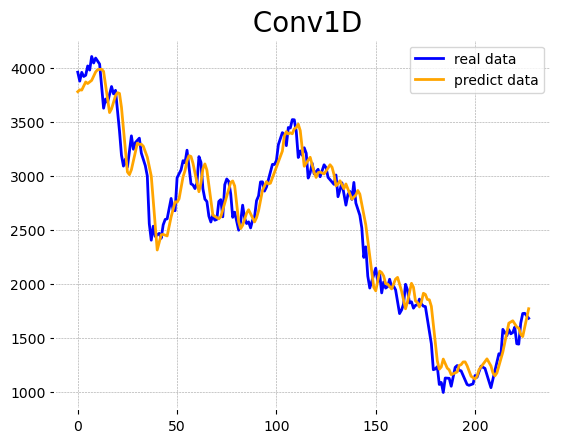

In [13]:
from sklearn.metrics import mean_absolute_error
plt.title(' Conv1D', size=20)
plt.plot(yValUnscaled,color='blue',label='real data')
plt.plot(predVal,color='orange',label='predict data')
plt.legend();
print( 'MSE=',correlate(predVal,yValUnscaled))
print( 'MAPE=',MAPE(predVal,yValUnscaled))

 LSTM

In [14]:
import tensorflow
modelL = Sequential()
modelL.add(LSTM(5, input_shape = (xLen, 5)))
modelL.add(Dense(10, activation="relu"))
modelL.add(Dense(1, activation="linear"))
modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))
modelL.summary()
history = modelL.fit(trainDataGen,epochs=100,verbose=2,validation_data=testDataGen)

(predVal, yValUnscaled) = getPred(modelL, xVal[0], yVal[0], yScaler)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 220       
                                                                 
 dense_4 (Dense)             (None, 10)                60        
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
231/231 - 2s - loss: 0.1719 - val_loss: 0.4998 - 2s/epoch - 8ms/step
Epoch 2/100
231/231 - 1s - loss: 0.1667 - val_loss: 0.4861 - 508ms/epoch - 2ms/step
Epoch 3/100
231/231 - 0s - loss: 0.1619 - val_loss: 0.4731 - 497ms/epoch - 2ms/step
Epoch 4/100
231/231 - 0s - loss: 0.1572 - val_loss: 0.4607 - 494ms/epoc

Epoch 88/100
231/231 - 0s - loss: 0.0339 - val_loss: 0.0897 - 454ms/epoch - 2ms/step
Epoch 89/100
231/231 - 0s - loss: 0.0331 - val_loss: 0.0874 - 451ms/epoch - 2ms/step
Epoch 90/100
231/231 - 0s - loss: 0.0322 - val_loss: 0.0854 - 455ms/epoch - 2ms/step
Epoch 91/100
231/231 - 0s - loss: 0.0313 - val_loss: 0.0832 - 455ms/epoch - 2ms/step
Epoch 92/100
231/231 - 0s - loss: 0.0304 - val_loss: 0.0812 - 443ms/epoch - 2ms/step
Epoch 93/100
231/231 - 0s - loss: 0.0296 - val_loss: 0.0790 - 442ms/epoch - 2ms/step
Epoch 94/100
231/231 - 0s - loss: 0.0287 - val_loss: 0.0769 - 443ms/epoch - 2ms/step
Epoch 95/100
231/231 - 0s - loss: 0.0278 - val_loss: 0.0747 - 445ms/epoch - 2ms/step
Epoch 96/100
231/231 - 0s - loss: 0.0270 - val_loss: 0.0726 - 445ms/epoch - 2ms/step
Epoch 97/100
231/231 - 0s - loss: 0.0262 - val_loss: 0.0704 - 443ms/epoch - 2ms/step
Epoch 98/100
231/231 - 0s - loss: 0.0253 - val_loss: 0.0683 - 441ms/epoch - 2ms/step
Epoch 99/100
231/231 - 0s - loss: 0.0245 - val_loss: 0.0661 - 451

MSE= 0.8480696312432158
MAPE= 62.9310489349047


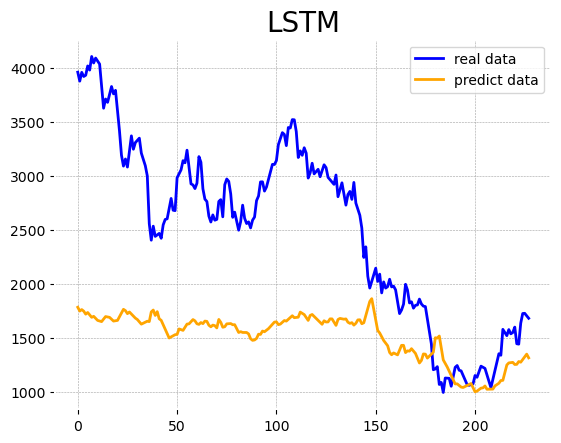

In [15]:
plt.title('LSTM', size=20)
plt.plot(yValUnscaled,color='blue',label='real data')
plt.plot(predVal,color='orange',label='predict data')
plt.legend();
print( 'MSE=',correlate(predVal,yValUnscaled))
print( 'MAPE=',MAPE(predVal,yValUnscaled))

 LSTM + Conv1D + Dense

Epoch 1/60
231/231 [==============================] - 5s 9ms/step - loss: 0.0191 - val_loss: 0.0033
Epoch 2/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 3/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 4/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 5/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 6/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 7/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 8/60
231/231 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 9/60
231/231 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/60
231/231 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0022

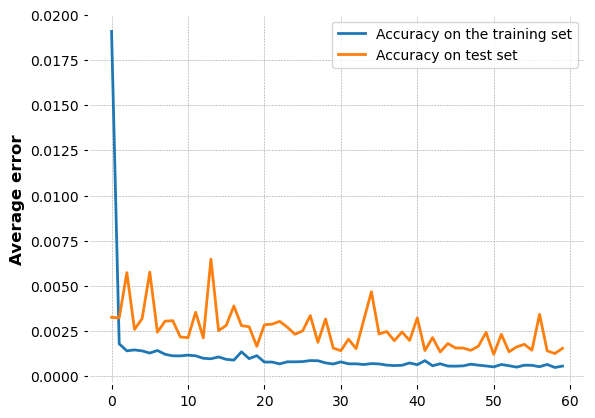

8/8 [==============================] - 1s 3ms/step
Epoch 1/15
231/231 [==============================] - 5s 8ms/step - loss: 4.2908e-04 - val_loss: 0.0012
Epoch 2/15
231/231 [==============================] - 1s 5ms/step - loss: 4.1274e-04 - val_loss: 0.0017
Epoch 3/15
231/231 [==============================] - 1s 5ms/step - loss: 4.2199e-04 - val_loss: 0.0014
Epoch 4/15
231/231 [==============================] - 1s 5ms/step - loss: 4.2340e-04 - val_loss: 0.0016
Epoch 5/15
231/231 [==============================] - 1s 5ms/step - loss: 4.1790e-04 - val_loss: 0.0015
Epoch 6/15
231/231 [==============================] - 1s 5ms/step - loss: 4.1966e-04 - val_loss: 0.0015
Epoch 7/15
231/231 [==============================] - 1s 5ms/step - loss: 4.1821e-04 - val_loss: 0.0020
Epoch 8/15
231/231 [==============================] - 1s 5ms/step - loss: 4.1916e-04 - val_loss: 0.0014
Epoch 9/15
231/231 [==============================] - 1s 5ms/step - loss: 4.1645e-04 - val_loss: 0.0016
Epoch 10/15
2

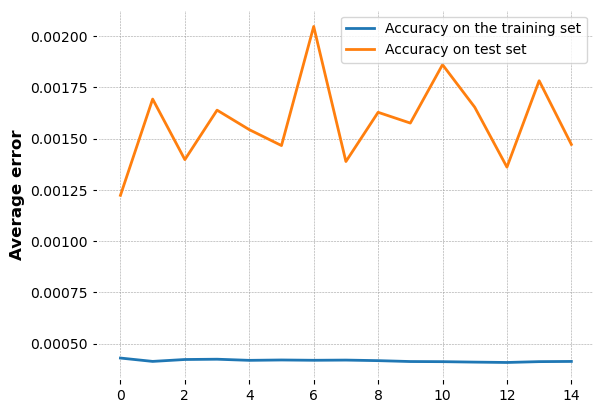

8/8 [==============================] - 1s 3ms/step


In [16]:
#כאן שכבת הקלט לוקחת את הנתונים שלנו
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))
# LSTM ו- Conv1D הן שכבות "זיכרון", כאן יש להן 100 נוירונים
lstmWay = LSTM(100, return_sequences="True")(dataInput)
# Conv1D בעל פונקציית הפעלת relu הממירה ערכים שליליים לאפס
convWay = Conv1D(100, 5, activation="relu")(dataInput)
lstmConvWay = Conv1D(100, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(100, return_sequences="True")(convWay)
lstmWay = LSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(100, 5, activation="relu")(convWay)
# Flattenזוהי שכבה שהופכת את המערך לחד מימדי, נמתחת למישור אחד
lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)
finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(100, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)
modelX = Model(dataInput, finWay)
modelX.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelX.fit_generator(trainDataGen,epochs=60,verbose=1,validation_data=testDataGen)
plt.plot(history.history['loss'],label='Accuracy on the training set')
plt.plot(history.history['val_loss'],label='Accuracy on test set')
plt.ylabel('Average error')
plt.legend()
plt.show()
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-6))
history = modelX.fit_generator(trainDataGen,epochs=15,verbose=1,validation_data=testDataGen)
plt.plot(history.history['loss'],label='Accuracy on the training set')
plt.plot(history.history['val_loss'],label='Accuracy on test set')
plt.ylabel('Average error')
plt.legend()
plt.show()

currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)


MSE= 0.9823143094360582
MAPE= 5.749113838985839


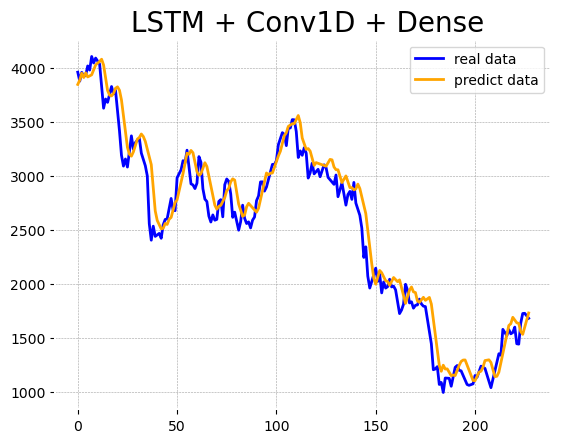

In [17]:
plt.title(' LSTM + Conv1D + Dense', size=20)
plt.plot(yValUnscaled,color='blue',label='real data')
plt.plot(predVal,color='orange',label='predict data')
plt.legend();
print( 'MSE=',correlate(predVal,yValUnscaled))
print( 'MAPE=',MAPE(predVal,yValUnscaled))

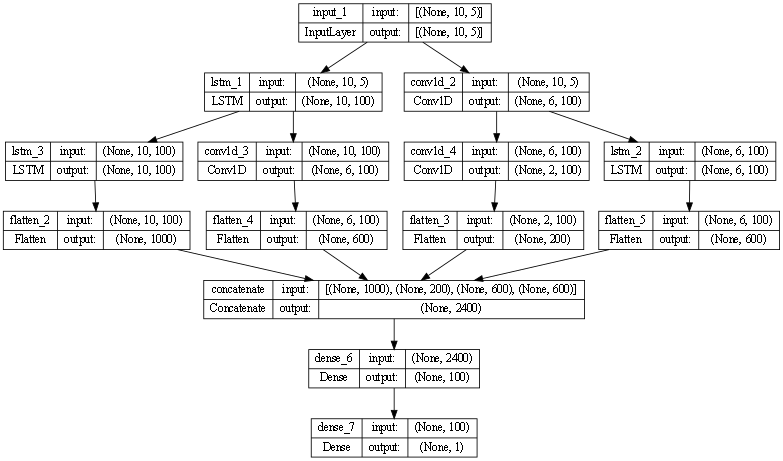

In [18]:
import pydotplus
from tensorflow.keras.utils import plot_model
plot_model(modelX, dpi=60, show_shapes=True)